# W-14

In [73]:
from FMM_BEM import read_geo_and_create_quadtree, assem_fmm, surf_plot, eval_sol, m2l_translation,upward_pass, l2l_translation, downward_pass
import matplotlib.pyplot as plt
import numpy as np

In [74]:
%matplotlib widget

In [75]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu, quadtree, boundary_points = read_geo_and_create_quadtree("files\disk.msh",[0, 1], [2, 3],max_points_quad=1,max_depth=20)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Santiago\AppData\Local\Temp\ipykernel_36624\705365263.py:1: SyntaxWarning: invalid escape sequence '\d'
  mesh, coords, elems, x_m, y_m, id_dir, id_neu, quadtree, boundary_points = read_geo_and_create_quadtree("files\disk.msh",[0, 1], [2, 3],max_points_quad=1,max_depth=20)


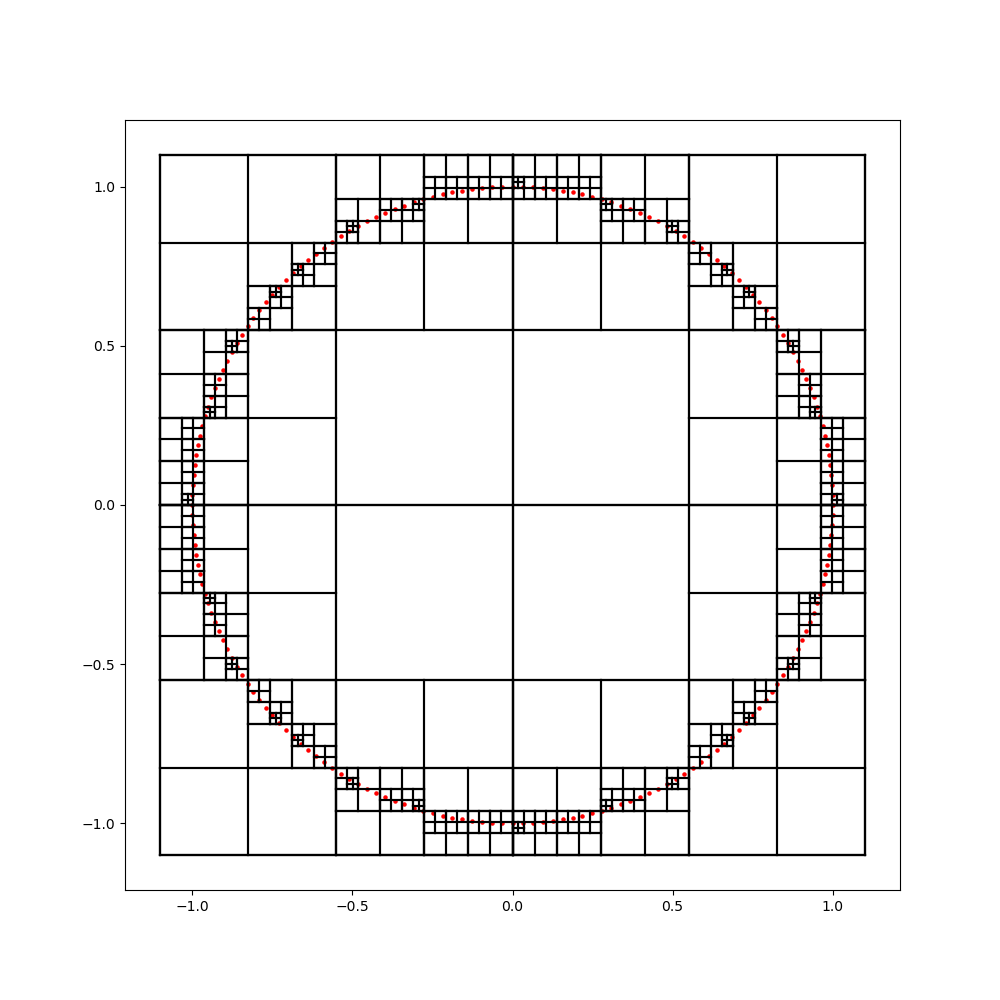

In [76]:
def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=5)  # Dibujar los puntos de la frontera
plt.show()

In [77]:
Gmat, Fmat = assem_fmm(coords,elems,quadtree,3)

In [78]:
upward_pass(quadtree.children[0].children[0],10)


array([ 1.30000000e+01+0.00000000e+00j,  1.59598907e+00+9.47760965e-01j,
        8.49661367e-03+1.09062132e-01j, -5.36730081e-02+1.96817919e-02j,
       -1.86826519e-02+8.06493410e-04j, -2.47799054e-03-3.45107976e-04j,
        1.36575117e-05-3.10083043e-05j,  1.06061150e-04-1.48475454e-05j,
        3.17715103e-05-2.53624923e-06j,  4.01190385e-06-4.49536446e-07j,
       -8.05970359e-08-1.34450046e-07j])

In [79]:
results = downward_pass(quadtree.children[0].children[0],3)
results

{<quadtree.Quadtree at 0x2d0bdc67080>: {<quadtree.Quadtree at 0x2d0bdc67080>: array([ -9.09492836 -8.69778343j,  -0.69122534-10.18563815j,
         -33.93336449+36.80547543j,  74.36140418 -2.35837957j])},
 <quadtree.Quadtree at 0x2d0bdc67f80>: {<quadtree.Quadtree at 0x2d0bdc67f80>: array([  -6.30653703 -23.7251313j ,  -43.66693092 -28.78413251j,
         -102.97763322+134.69463812j,  299.31768443+273.92304874j])},
 <quadtree.Quadtree at 0x2d0bdc647a0>: {<quadtree.Quadtree at 0x2d0bdc647a0>: array([ -22.12093613  -5.53307282j,   36.366583   -28.8263579j ,
         -115.58190713+101.62236656j,  253.84859414-257.57922387j])},
 <quadtree.Quadtree at 0x2d0bdc64aa0>: {<quadtree.Quadtree at 0x2d0bdc66db0>: {<quadtree.Quadtree at 0x2d0bdc66db0>: array([ -17.32469641 -19.85806595j,  -12.7599022  -59.56972416j,
          -543.48454547+557.66063054j, 3201.5275714 +336.10115645j])},
  <quadtree.Quadtree at 0x2d0bdc677a0>: {<quadtree.Quadtree at 0x2d0bdc666c0>: {<quadtree.Quadtree at 0x2d0bdc666c0>

In [80]:
for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = np.mean(coords[elem2], axis=0)

            # Usamos find_point_location para obtener los nodos correspondientes a cada elemento
            node_info1 = quadtree.find_point_location(np.mean(coords[elem1], axis=0))
            node_info2 = quadtree.find_point_location(pt_col)
            
            node1 = node_info1['leaf']
            node2 = node_info2['leaf']

            interaction_list = node1.compute_interaction_list()
            if node2 in interaction_list:
                    dx = node2.center[0] - node1.center[0]
                    dy = node2.center[1] - node1.center[1]
                    # Traducción multipolar M2L para interacciones lejanas
                    print(np.real(m2l_translation(node2.multipole_moments, dx, dy, 10)[-1]))
                    print(np.real(l2l_translation(node2.local_expansion, dx, dy, 10)[-1]))

560652752227441.44
0.0
8472081364.539465
9.242468064378274
8472081364.539465
9.242468064378274
348965993559.454
-0.3120636217956902
348965993559.454
-0.3120636217956902
46175645765419.555
0.0
46175645765419.555
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-156213740744889.22
0.0
-156213740744889.22
0.0
-224037364055.14297
-0.919714178736488
-224037364055.14297
-0.919714178736488
-7981136412.001251
2.5395014233815005
-7981136412.001251
2.5395014233815005
446299915203389.4
0.0
7981136162.758935
-2.539501231488986
7981136162.758935
-2.539501231488986
224037361501.67377
0.9197141120760846
224037361501.67377
0.9197141120760846
156213748521655.84
0.0
156213748521655.84
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-46175643826323.9
0.0
-46175643826323.9
0.0
-348966008170.8738
0.3120636434556106
-348966008170.8738
0.3120636434556106
-8472081544.457907
-9.242468728964544
-8472081544.457907
-9.242468728964544
-560652752227413.6
0.0
-8472081364.539465
-9.242468064378274
-8472081364.539465
-9.242468064378274
-34896

In [81]:
Gmat

array([[0.02576708, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01752836],
       [0.        , 0.02576708, 0.01752836, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01752836, 0.02576708, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02576708, 0.01752836,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01752836, 0.02576708,
        0.01752836],
       [0.01752836, 0.        , 0.        , ..., 0.        , 0.01752836,
        0.02576708]])

In [82]:
Fmat

array([[-0.5       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00333339],
       [ 0.        , -0.5       ,  0.00333339, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00333339, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.5       ,
         0.00333339,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.00333339,
        -0.5       ,  0.00333339],
       [ 0.00333339,  0.        ,  0.        , ...,  0.        ,
         0.00333339, -0.5       ]])

In [83]:
A = np.zeros_like(Fmat)
B = np.zeros_like(Fmat)

In [84]:
A[np.ix_(id_dir, id_dir)] = Gmat[np.ix_(id_dir, id_dir)]
A[np.ix_(id_dir, id_neu)] = -Fmat[np.ix_(id_dir, id_neu)]
A[np.ix_(id_neu, id_dir)] = Gmat[np.ix_(id_neu, id_dir)]
A[np.ix_(id_neu, id_neu)] = -Fmat[np.ix_(id_neu, id_neu)]


In [85]:
B[np.ix_(id_dir, id_dir)] = Fmat[np.ix_(id_dir, id_dir)]
B[np.ix_(id_dir, id_neu)] = -Gmat[np.ix_(id_dir, id_neu)]
B[np.ix_(id_neu, id_dir)] = Fmat[np.ix_(id_neu, id_dir)]
B[np.ix_(id_neu, id_neu)] = -Gmat[np.ix_(id_neu, id_neu)]

In [86]:
theta = np.unwrap(np.arctan2(y_m, x_m))
rhs = np.zeros(elems.shape[0])
rhs[id_dir] = 3*np.cos(6*theta[id_dir])
rhs[id_neu] = -18*np.cos(6*theta[id_neu])

In [87]:
from numpy.linalg import norm, solve
sol = solve(A, B.dot(rhs))

In [88]:
u_bound = np.zeros_like(sol)
q_bound = np.zeros_like(sol)
u_bound[id_dir] = rhs[id_dir]
u_bound[id_neu] = sol[id_neu]
q_bound[id_dir] = sol[id_dir]
q_bound[id_neu] = rhs[id_neu]

In [89]:
solution = eval_sol(mesh.points[:, :2], coords, elems, u_bound, q_bound)

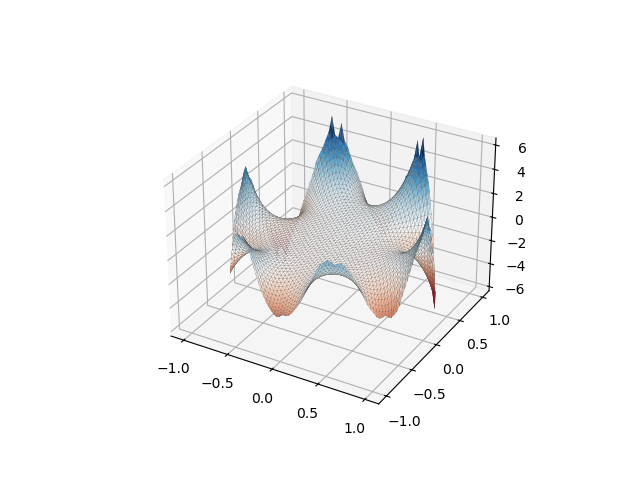

In [90]:
ax = surf_plot(mesh, 4, solution)